In [1]:
""" To Do List
1)Find suitable groups based on spining data
2)Fins theh x,y,z distribution for all of the neurites
Find the length distribution for all of the neurites
Find the volume distribution for all of the neurites
Find the x, y, z distribution for all of the spining groups
For For all spining groups:
Take out the dendrite numbers and filter by size
Do heat map of compartments


"""

' To Do List\n1)Find suitable groups based on spining data\n2)Fins theh x,y,z distribution for all of the neurites\nFind the length distribution for all of the neurites\nFind the volume distribution for all of the neurites\nFind the x, y, z distribution for all of the spining groups\nFor For all spining groups:\nTake out the dendrite numbers and filter by size\nDo heat map of compartments\n\n\n'

In [2]:
import datajoint as dj
import numpy as np
import time

from meshparty import trimesh_io
import pandas as pd
import seaborn as sns
sns.set() #sets the asethetics parameters in what set

In [3]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20

schema = dj.schema('microns_ta3p100')
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')


Connecting celiib@10.28.0.34:3306


In [ ]:
#ta3p100.NeuriteTargetsRevised.describe()

In [ ]:
#NeuriteTargets was recomputed from the NeuriteRevised list
len(ta3p100.NeuriteTargetsRevised() & "spine_num<total"),len(ta3p100.NeuriteTargetsRevised() )

In [ ]:
ta3p100.NeuriteTargetsRevised()

In [4]:
#creates the table with spine data without the spine label
#how to filter out the spine proportion

#have to first remove the ones that have only spine synapses


neurite_targets_no_spine = (ta3p100.NeuriteTargetsRevised() & "(spine_num + spine_neck_num) <total").proj(
                                                         spine_head_prop="spine_head_prop/(1-spine_prop - spine_neck_prop)",
                                                         shaft_prop="shaft_prop/(1-spine_prop - spine_neck_prop)",
                                                         #non_spine_prop="non_spine_prop/(1-spine_prop - spine_neck_prop)",
                                                         soma_prop = "soma_prop/(1-spine_prop - spine_neck_prop)",
                                                         axon_prop = "axon_prop/(1-spine_prop - spine_neck_prop)",
                                                         total="total-spine_num - spine_neck_num",
                                            )

neurite_targets_no_spine



segmentation segmentation id,segment_id segment id unique within each Segmentation,spine_head_prop calculated attribute,shaft_prop calculated attribute,soma_prop calculated attribute,axon_prop calculated attribute,total calculated attribute
2,648518346341351467,1.0,0.0,0.0,0.0,5.0
2,648518346341351503,1.0,0.0,0.0,0.0,5.0
2,648518346341351508,0.25,0.25,0.5,0.0,4.0
2,648518346341351509,1.0000000173846881,0.0,0.0,0.0,6.0
2,648518346341351512,0.8750000157160684,0.1250000010477379,0.0,0.0,8.0
2,648518346341351514,1.0,0.0,0.0,0.0,6.0
2,648518346341351518,1.0,0.0,0.0,0.0,4.0
2,648518346341351523,1.0,0.0,0.0,0.0,3.0
2,648518346341351525,0.8749999883584678,0.12500000232830644,0.0,0.0,8.0
2,648518346341351531,1.0,0.0,0.0,0.0,3.0


In [5]:
#different lengths based on the number of synapses threshold

print(len(neurite_targets_no_spine))
print(len(neurite_targets_no_spine & "total>12"))
print(len(neurite_targets_no_spine & "total>10")) 
print(len(neurite_targets_no_spine & "total>8")) 
print(len(neurite_targets_no_spine & "total>6")) 

31966
886
1624
3128
6268


# Manually seperating the groups into: Axon, Soma, Head, Shaft

In [6]:
neurite_targets_no_spine_6 = (neurite_targets_no_spine & "total>6")
print("Total in neurite table with greater than 6 synapses = " + str(len(neurite_targets_no_spine_6)))

Total in neurite table with greater than 6 synapses = 6268


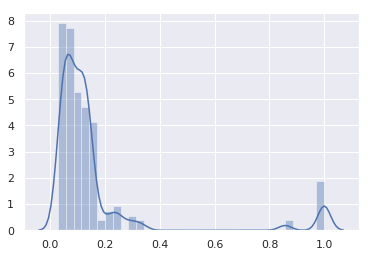

In [7]:
#show the distribution
axon_prop = neurite_targets_no_spine_6.fetch("axon_prop")
axon_prop
axon_greater_0_array = axon_prop[axon_prop.astype("float") > 0]
sns.distplot(axon_greater_0_array.astype("float"))

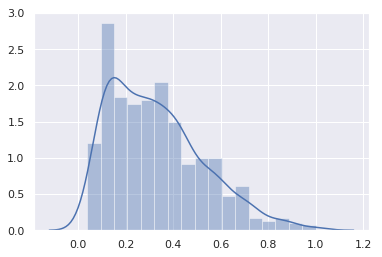

In [10]:
#show the distribution
soma_prop = (neurite_targets_no_spine_6 ).fetch("soma_prop")
soma_prop
soma_greater_0_array = soma_prop[soma_prop.astype("float") > 0]
sns.distplot(soma_greater_0_array.astype("float"))

In [11]:
#manually find the groups
axon_group = neurite_targets_no_spine_6 & "axon_prop>0"
print("Axon group = " + str(len(axon_group)))
soma_group = (neurite_targets_no_spine_6 - axon_group.proj()) & "soma_prop>=0.25"
print("Soma group = " + str(len(soma_group)))

Axon group = 186
Soma group = 501


In [12]:
#remove the axon and soma groups
neurite_targets_no_spine_6_without_axon_soma = neurite_targets_no_spine_6 - axon_group.proj() - soma_group.proj()
len(neurite_targets_no_spine_6_without_axon_soma)/len(neurite_targets_no_spine_6)

0.8903956604977664

In [13]:
#get heatmap of the data

neurite_spine_data = neurite_targets_no_spine_6_without_axon_soma.fetch(as_dict=True)

spine_df = pd.DataFrame(neurite_spine_data)
spine_df_base = spine_df.drop(columns=['segmentation', 'segment_id',"total","axon_prop","soma_prop"])
#spine_df_base

In [14]:
#sort by the first column and then do heat map
spine_df_base_head_shaft_sort = spine_df_base.sort_values(['spine_head_prop','shaft_prop'], ascending=[False,True])
spine_df_base_head_shaft_sort

,spine_head_prop,shaft_prop
4034,1.0,0.0
172,1.0,0.0
1294,1.0,0.0
2516,1.0,0.0
3319,1.0,0.0
3606,1.0,0.0
3358,1.0,0.0
661,1.0,0.0
1561,1.0,0.0
3,1.0,0.0


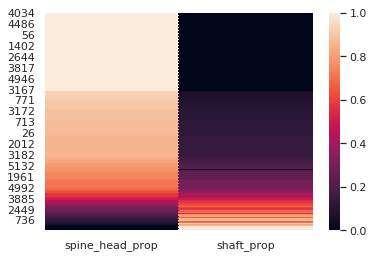

In [15]:
#heat map of spine heads
spine_head_shaft_sort = sns.heatmap(spine_df_base_head_shaft_sort)

In [17]:
#making the head group
head_group = neurite_targets_no_spine_6_without_axon_soma & "spine_head_prop >=0.6"
len(head_group)

4642

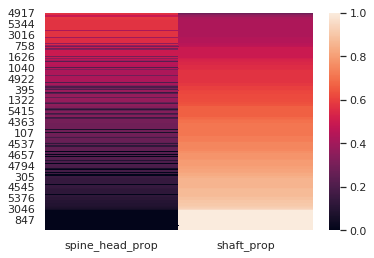

In [18]:
#heat map of spine heads
spine_shaft = spine_df_base_head_shaft_sort[spine_df_base_head_shaft_sort["spine_head_prop"]<0.6].sort_values("shaft_prop",ascending=True)
#spine_df_base_head_shaft_sort = spine_df_base.sort_values(['spine_head_prop','shaft_prop'], ascending=[False,True])
spine_head_shaft_sort = sns.heatmap(spine_shaft)

In [19]:
#making the shaft group
shaft_group = (neurite_targets_no_spine_6_without_axon_soma & "shaft_prop >=0.5") - head_group.proj()
len(shaft_group)

783

In [20]:
unused = neurite_targets_no_spine_6_without_axon_soma - head_group.proj() - shaft_group.proj()

In [22]:
print(len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused))
print(sum([len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused)]))

501 186 4642 783 156
6268


In [23]:
print(len(neurite_targets_no_spine_6))

6268


In [ ]:
ta3p100.LabelKey.describe()

In [25]:
ta3p100.SpineClustersKey.drop()

`microns_ta3p100`.`#spine_clusters_key` (5 tuples)
`microns_ta3p100`.`spine_clusters` (0 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


In [26]:
#look up datajoint table that has the clusters
@schema
class SpineClustersKey(dj.Lookup):
    definition="""
    cluster_id : tinyint unsigned #numeric label of cluster
    ---
    description : varchar(16) #descriptive name of cluster
    threshold   : float #the proportion cut off for the group based on the category
    """
    

In [27]:
cluster_descriptions = ["Soma","Axon","Spine Head","Shaft","Unused"]
cluster_thresholds = [0.25,0.0001,0.6,0.5,0]

clusters_dict = [dict(cluster_id=i,description=cd,threshold=ct) for i,(cd,ct) in enumerate(zip(cluster_descriptions,cluster_thresholds))]
clusters_dict

[{'cluster_id': 0, 'description': 'Soma', 'threshold': 0.25},
 {'cluster_id': 1, 'description': 'Axon', 'threshold': 0.0001},
 {'cluster_id': 2, 'description': 'Spine Head', 'threshold': 0.6},
 {'cluster_id': 3, 'description': 'Shaft', 'threshold': 0.5},
 {'cluster_id': 4, 'description': 'Unused', 'threshold': 0}]

In [28]:
SpineClustersKey.insert(clusters_dict,skip_duplicates=True)

In [ ]:
SpineClustersKey()

In [35]:
## Creates the table that holds all of the segment groups
@schema
class SpineClusters(dj.Manual):
    definition="""
    -> ta3p100.NeuriteRevised
    ---
    ->SpineClustersKey
    """

In [33]:
soma_group.proj(cluster_id="0")

segmentation segmentation id,segment_id segment id unique within each Segmentation,cluster_id calculated attribute
2,648518346341351904,0
2,648518346341352442,0
2,648518346341352789,0
2,648518346341353247,0
2,648518346341353475,0
2,648518346341354698,0
2,648518346341354845,0
2,648518346341355237,0
2,648518346341355500,0
2,648518346341355509,0


In [32]:
dict = SpineClustersKey.fetch(as_dict=True)
dict

In [36]:
possible_groups = [soma_group,axon_group,head_group,shaft_group,unused]
descriptors = [0,1,2,3,4]
for i,table in enumerate(possible_groups):
    new_table = table.proj(cluster_id=str(descriptors[i]))
    SpineClusters.insert(new_table,skip_duplicates=True)
    

In [38]:
(len(SpineClusters() & "cluster_id=0"),len(SpineClusters() & "cluster_id=1"),
 len(SpineClusters() & "cluster_id=2"),len(SpineClusters() & "cluster_id=3"),
 len(SpineClusters() & "cluster_id=4"))

(501, 186, 4642, 783, 156)

In [39]:
print(len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused))
print(sum([len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused)]))

501 186 4642 783 156
6268
